In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099624.00 MB
Memory usage after optimization is: 16520255.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [5]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

# 简单建模

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [7]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416419136),
 ('v_8', 700675.5609398606),
 ('v_9', 170630.2772321968),
 ('v_7', 32322.6619320174),
 ('v_12', 20473.670796954273),
 ('v_3', 17868.07954149409),
 ('v_11', 11474.938996679144),
 ('v_13', 11261.764560014137),
 ('v_10', 2683.920090624845),
 ('gearbox', 881.822503924722),
 ('fuelType', 363.90425072169467),
 ('bodyType', 189.6027101207212),
 ('city', 44.94975120522734),
 ('power', 28.553901616756225),
 ('brand_price_median', 0.5103728134078392),
 ('brand_price_std', 0.45036347092631823),
 ('brand_amount', 0.14881120395066025),
 ('brand_price_max', 0.0031910186703121924),
 ('SaleID', 5.3559899198622415e-05),
 ('seller', 6.635207682847977e-06),
 ('train', 3.999797627329826e-06),
 ('offerType', 3.6582350730895996e-06),
 ('brand_price_sum', -2.1750068681876494e-05),
 ('name', -0.000298001271304757),
 ('used_time', -0.0025158943328485923),
 ('brand_price_average', -0.40490484510108166),
 ('brand_price_min', -2.246775348688867),
 ('power_bin', -34.42064411728735),
 

In [8]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

The predicted price is obvious different from true price


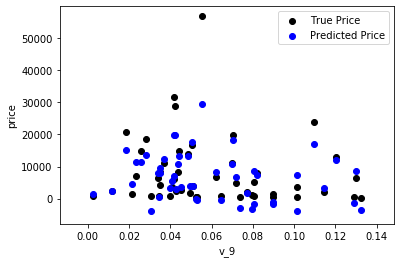

In [9]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


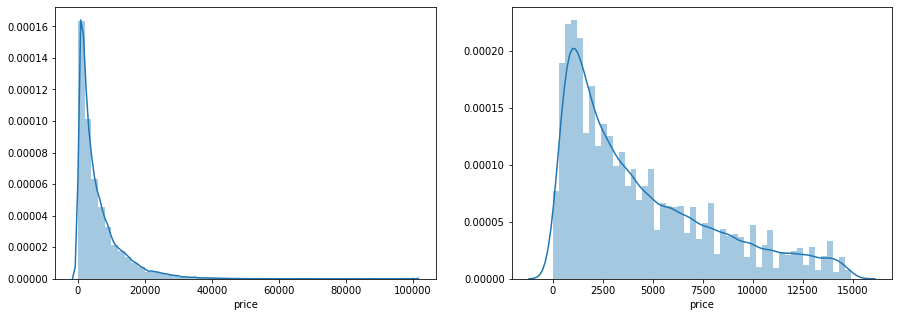

In [10]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [11]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


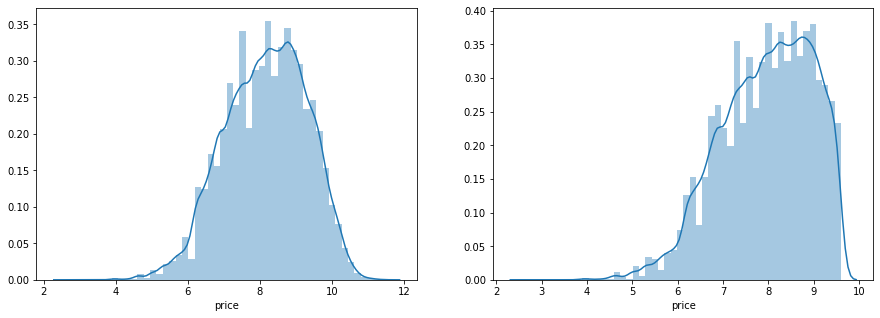

In [12]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [13]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074946569724


[('v_9', 8.052409900566468),
 ('v_5', 5.76423659664997),
 ('v_12', 1.6182081236789159),
 ('v_1', 1.4798310582985728),
 ('v_11', 1.166901656359704),
 ('v_13', 0.9404711296034179),
 ('v_7', 0.713727308355897),
 ('v_3', 0.6837875771083692),
 ('v_0', 0.008500518010004975),
 ('power_bin', 0.008497969302894069),
 ('gearbox', 0.007922377278333597),
 ('fuelType', 0.006684769706831896),
 ('bodyType', 0.004523520092704097),
 ('power', 0.0007161894205356891),
 ('brand_price_min', 3.334351114746724e-05),
 ('brand_amount', 2.8978797042774904e-06),
 ('brand_price_median', 1.2571172873072747e-06),
 ('brand_price_std', 6.659176363473903e-07),
 ('brand_price_max', 6.19495630751721e-07),
 ('brand_price_average', 5.999345964987148e-07),
 ('SaleID', 2.1194170039650885e-08),
 ('seller', 3.4079761235261685e-10),
 ('offerType', -7.295852810784709e-11),
 ('train', -1.197975052491529e-10),
 ('brand_price_sum', -1.5126504215925019e-10),
 ('name', -7.015512588894367e-08),
 ('used_time', -4.1224793723510605e-06),

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


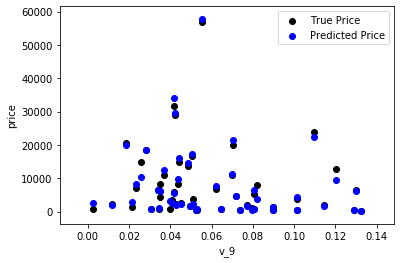

In [14]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [16]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [17]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [18]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313986


In [19]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,1.348304,1.36349,1.380712,1.378401,1.358105


In [20]:
import datetime

In [21]:
sample_feature = sample_feature.reset_index(drop=True)

In [22]:
split_point = len(sample_feature) // 5 * 4

In [23]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [24]:
model = model.fit(train_X, train_y_ln)

In [25]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.1957766727030097